# HW 2: Clustering and Topic Models [100 points]

Name: Zhining Zhou

Andrew ID: zhiningz
 
Collaborators (if none, say "none"; do *not* leave this blank): Shawn Hu

Reminder: you should not be sharing code.

## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). Data is provided in the `enron` data directory, with one file per email. The data set includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam. 

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the makeWordList function, construct a list of processed documents.

In [22]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [23]:
########################################################################
######################### Write your code here #########################
########################################################################
import glob
email_list = glob.glob('./data/enron/*.txt')

s = []
for i in range(len(email_list)):
    s.append(makeWordList(email_list[i]))

### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [24]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=50,stop_words="english", max_df=0.8)
X = vectorizer.fit_transform(s)


### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix X using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [38]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, n_init=100, random_state=0)
gmm.fit(X.toarray())
gmm_cluster_assignments = gmm.predict(X.toarray())

In [39]:
for i in range(3):
    print("number of documents assigned to cluster: " , i)
    print(len(gmm_cluster_assignments[gmm_cluster_assignments == i]))

number of documents assigned to cluster:  0
2343
number of documents assigned to cluster:  1
915
number of documents assigned to cluster:  2
1913


### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes four parameters:
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [41]:
def plot_spam_words_by_cluster(predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

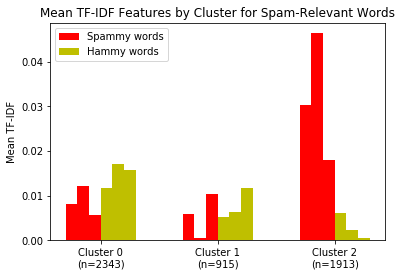

In [50]:
########################################################################
######################### Write your code here #########################
########################################################################
%matplotlib inline
list_features = vectorizer.get_feature_names()
idx1 = list_features.index('www')
idx2 = list_features.index('click')
idx3 = list_features.index('offer')
spam_indices = [idx1, idx2, idx3]
i1 = list_features.index('meeting')
i2 = list_features.index('attached')
i3 = list_features.index('review')
ham_indices = [i1, i2, i3]

plot_spam_words_by_cluster(gmm_cluster_assignments, 3, spam_indices, ham_indices)

### Part E: Interpret results [10 points]

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

*** Cluster 2 correspond to spam emails as the frequency of spammy words is way more higher than hammy words. Cluster 0 appear to correspond to typical business emails in terms of frequency of hammy words.  From the figure, n_clusters=3 appear better. ***

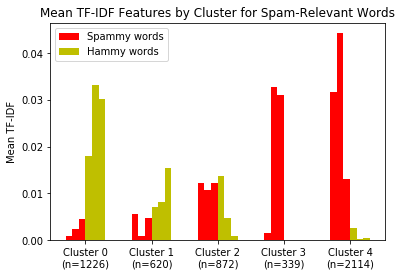

In [52]:
########################################################################
######################### Write your code here #########################
########################################################################
gmm = GaussianMixture(n_components=5, n_init=100, random_state=0)
gmm.fit(X.toarray())
gmm_cluster_assignments = gmm.predict(X.toarray())

plot_spam_words_by_cluster(gmm_cluster_assignments, 5, spam_indices, ham_indices)


## Question 2: Latent "Purposes" in Mobile Apps [45 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [2]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [3]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [4]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [5]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.as_matrix()
#del df # uncomment to free up RAM
#del df_perms # uncomment to free up RAM

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [6]:
del df
del df_perms

### Part C: Downweight "stop-words" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [7]:
X.shape

(180295, 173)

In [8]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_transform = transformer.fit_transform(X)

### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [9]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, n_jobs=-1, max_iter=10)
lda.fit(X_transform)


CPU times: user 14.4 s, sys: 1.52 s, total: 15.9 s
Wall time: 4min 9s


Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

In [10]:
topic_word_distributions = np.array([topic_word_pseudocounts / np.sum(topic_word_pseudocounts)
                                     for topic_word_pseudocounts in lda.components_])

num_top_words = 10

print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
print()

import numpy as np
for topic_idx in range(10):
    print('[Topic %d]' % topic_idx)
    sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print('%s: %f' % (permission_columns[word_idx], topic_word_distributions[topic_idx, word_idx]))
    print()

Displaying the top 10 words per topic and their probabilities within the topic...

[Topic 0]
System tools : prevent device from sleeping (D): 0.343092
Storage : modify/delete USB storage contents modify/delete SD card contents (D): 0.319512
Network communication : full Internet access (D): 0.160887
Phone calls : read phone state and identity (D): 0.069689
Network communication : view network state (S): 0.064923
System tools : disable keylock (D): 0.037647
Default : delete other applications' caches (S): 0.002824
Default : power device on or off (S): 0.000411
Default : coarse (network-based) location (S): 0.000207
Default : modify/delete USB storage contents modify/delete SD card contents (S): 0.000044

[Topic 1]
Hardware controls : take pictures and videos (D): 0.116495
Hardware controls : record audio (D): 0.078093
Storage : modify/delete USB storage contents modify/delete SD card contents (D): 0.062020
Network communication : full Internet access (D): 0.048098
Hardware controls : cha

*** Topic 2: personal information ***

*** Topic 3 : network and device settings ***

*** Topic 7: Messages ***

### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [10]:
app_distribution = lda.transform(X_transform)

In [12]:
########################################################################
######################### Write your code here #########################
########################################################################
for i in range(10):
    print("Top 3 apps for topic", i)
    sort_indices2 = np.argsort(app_distribution[:, i])[::-1]
    li = []
    for idx in sort_indices2:
        if (app_ratings[idx] > 100000 and len(li) < 3):
            li.append(app_names[idx])
            print(app_names[idx])
        if (len(li) == 3):
            break
    print()

Top 3 apps for topic 0
Real BlackJack
Robo Defense FREE
SpeechSynthesis Data Installer

Top 3 apps for topic 1
Evernote
TiKL
Movies

Top 3 apps for topic 2
Dolphin Browser™ HD
Dolphin Browser??? HD
Skyfire Web Browser 4.0

Top 3 apps for topic 3
World Newspapers
Paradise Island
My Country

Top 3 apps for topic 4
Wallpapers HD
Strip Poker
chompSMS

Top 3 apps for topic 5
Inotia3: Children of Carnia
YouTube
Ringdroid

Top 3 apps for topic 6
Dictionary.com
Air Control Lite
Paper Toss

Top 3 apps for topic 7
Adobe Reader
Gmail
SpeechSynthesis Data Installer

Top 3 apps for topic 8
Seesmic (Facebook, Twitter)
Meet New People
eBuddy Messenger

Top 3 apps for topic 9
Live Holdem Poker Pro
Vaulty Free Hides Pictures
Bubble Blast 2



### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [10 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

In [11]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate=1200, init='pca',angle=0.99, perplexity=70, random_state=0)
X_tsne = tsne.fit_transform(app_distribution[:2000])


CPU times: user 12.9 s, sys: 1.59 s, total: 14.5 s
Wall time: 15 s


In [12]:
X_label = np.argmax(app_distribution[:2000], axis=1)

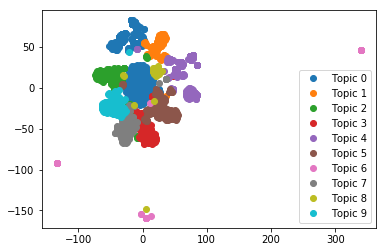

In [22]:
for i in range(10):
        plt.plot(X_tsne[X_label==i,0], X_tsne[X_label==i,1],'o',
                 label="Topic " + str(i))
plt.legend(loc='lower right')


## Question 3: Questionnaire [5 points]

Please answer this survey after you have done this homework: https://goo.gl/forms/qi1acwKwxSfNJfjt1